# **Digit Recognizer**

# Import necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
torch.manual_seed(42)
np.random.seed(42)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


# Data Preprocessing

In [8]:
train_csv = "/kaggle/input/digit-recognizer/train.csv"
test_csv = "/kaggle/input/digit-recognizer/test.csv"
sub_csv = "/kaggle/input/digit-recognizer/sample_submission.csv"
data = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)
submission = pd.read_csv(sub_csv)

In [9]:
data_np = data.to_numpy()
# labels are in first column
y_all = data_np[:, 0].astype(np.int64)
x = data_np[:, 1:].reshape(-1, 28, 28).astype(np.uint8)  # [N, 28, 28]

# Test images (no labels)
test_data = test.to_numpy()
x_test = test_data.reshape(-1, 28, 28).astype(np.uint8)  # [N_test, 28, 28]

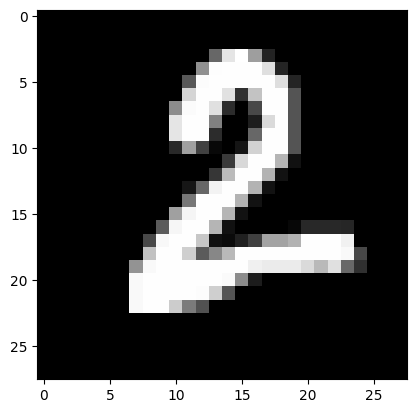

In [10]:
# Quick sanity plot (optional)
plt.imshow(x[1018], cmap='gray')
plt.show()

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.labels = data_df.iloc[:, 0].values.astype(np.int64)
        self.images = data_df.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

In [13]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [14]:
dataset = CustomDataset(data, transform=transform)

# Training the model

In [21]:
# Split the data into training and Validation set

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [22]:
class val_wrapper(Dataset):
    '''This function ensures that the validation data is processed in determinant way'''
    def __init__(self, subset, eval_transform):
        self.subset = subset
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        orig_idx = self.subset.indices[idx]
        raw_img = Image.fromarray(data.iloc[orig_idx, 1:].values.reshape(28, 28).astype(np.uint8))
        img = self.eval_transform(raw_img)
        return img, int(data.iloc[orig_idx, 0])

valid_dataset = val_wrapper(valid_dataset, transform_eval)

In [25]:
# Data Loader

batch_size = 64
train_ = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_ = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [26]:
# Residual Block

class Residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Residual_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [28]:
# CNN model for Classifing handwritten digit classification (0–9) based in ResNet 

class CustomModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.layers(64, 2, stride=1)
        self.layer2 = self.layers(128, 2, stride=2)
        self.layer3 = self.layers(256, 2, stride=2)
        self.layer4 = self.layers(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def layers(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(Residual_block(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [39]:
# Custom training framework for the digit recognizer CNN with evaluation and prediction utilities

class SimpleCNN_net:
    def __init__(self, model, train_dl, valid_dl, lr=0.001, weight_decay=0.0005, device=torch.device("cpu")):
        self.device = device
        self.model = model.to(self.device)
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss_fn = nn.CrossEntropyLoss()

    def train(self, epochs=10):
        history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            train_preds = []
            train_labels = []
            for x, y in tqdm(self.train_dl, desc=f"Train Epoch {epoch+1}/{epochs}"):
                x = x.to(self.device)
                y = y.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(x)
                loss = self.loss_fn(out, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                preds = out.argmax(1).detach().cpu().numpy()
                train_preds.extend(preds.tolist())
                train_labels.extend(y.detach().cpu().numpy().tolist())
            train_loss /= len(self.train_dl)
            train_acc = accuracy_score(train_labels, train_preds)

            self.model.eval()
            valid_loss = 0.0
            valid_preds = []
            valid_labels = []
            with torch.no_grad():
                for x, y in tqdm(self.valid_dl, desc=f"Valid Epoch {epoch+1}/{epochs}"):
                    x = x.to(self.device)
                    y = y.to(self.device)
                    out = self.model(x)
                    loss = self.loss_fn(out, y)
                    valid_loss += loss.item()
                    preds = out.argmax(1).detach().cpu().numpy()
                    valid_preds.extend(preds.tolist())
                    valid_labels.extend(y.detach().cpu().numpy().tolist())
            valid_loss /= len(self.valid_dl)
            valid_acc = accuracy_score(valid_labels, valid_preds)

            history["train_loss"].append(train_loss)
            history["valid_loss"].append(valid_loss)
            history["train_acc"].append(train_acc)
            history["valid_acc"].append(valid_acc)

            print(f"Epoch {epoch+1}: "
                  f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Valid Loss={valid_loss:.4f}, Valid Acc={valid_acc:.4f}")

        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["valid_loss"], label="Valid Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training vs Validation Loss")
        plt.show()

    def predict(self, x_arr, sub):
        self.model.eval()
        with torch.no_grad():
            for i in range(x_arr.shape[0]):
                img = x_arr[i].astype(np.uint8)
                img_pil = Image.fromarray(img)
                img_t = transform_eval(img_pil).unsqueeze(0).to(self.device)  # [1,1,28,28]
                output = self.model(img_t)
                pred_class = output.argmax(dim=1).item()
                sub[i] = pred_class
        return sub


Valid Epoch 1/15: 100%|██████████| 132/132 [00:03<00:00, 40.40it/s]


Epoch 1: Train Loss=0.1987, Train Acc=0.9378, Valid Loss=0.1111, Valid Acc=0.9654


Valid Epoch 2/15: 100%|██████████| 132/132 [00:03<00:00, 39.08it/s]


Epoch 2: Train Loss=0.0883, Train Acc=0.9732, Valid Loss=0.0673, Valid Acc=0.9808


Valid Epoch 3/15: 100%|██████████| 132/132 [00:03<00:00, 38.12it/s]


Epoch 3: Train Loss=0.0800, Train Acc=0.9771, Valid Loss=0.0624, Valid Acc=0.9820


Valid Epoch 4/15: 100%|██████████| 132/132 [00:03<00:00, 38.40it/s]


Epoch 4: Train Loss=0.0692, Train Acc=0.9794, Valid Loss=0.0687, Valid Acc=0.9824


Valid Epoch 5/15: 100%|██████████| 132/132 [00:03<00:00, 39.38it/s]


Epoch 5: Train Loss=0.0635, Train Acc=0.9824, Valid Loss=0.0457, Valid Acc=0.9873


Valid Epoch 6/15: 100%|██████████| 132/132 [00:03<00:00, 40.46it/s]


Epoch 6: Train Loss=0.0603, Train Acc=0.9831, Valid Loss=0.0590, Valid Acc=0.9821


Valid Epoch 7/15: 100%|██████████| 132/132 [00:03<00:00, 39.79it/s]


Epoch 7: Train Loss=0.0608, Train Acc=0.9823, Valid Loss=0.0650, Valid Acc=0.9810


Valid Epoch 8/15: 100%|██████████| 132/132 [00:03<00:00, 39.72it/s]


Epoch 8: Train Loss=0.0546, Train Acc=0.9847, Valid Loss=0.0546, Valid Acc=0.9849


Valid Epoch 9/15: 100%|██████████| 132/132 [00:03<00:00, 40.70it/s]


Epoch 9: Train Loss=0.0556, Train Acc=0.9841, Valid Loss=0.0471, Valid Acc=0.9881


Valid Epoch 10/15: 100%|██████████| 132/132 [00:03<00:00, 40.24it/s]


Epoch 10: Train Loss=0.0483, Train Acc=0.9863, Valid Loss=0.0532, Valid Acc=0.9857


Valid Epoch 11/15: 100%|██████████| 132/132 [00:03<00:00, 39.23it/s]


Epoch 11: Train Loss=0.0483, Train Acc=0.9855, Valid Loss=0.0419, Valid Acc=0.9876


Valid Epoch 12/15: 100%|██████████| 132/132 [00:03<00:00, 40.67it/s]


Epoch 12: Train Loss=0.0439, Train Acc=0.9873, Valid Loss=0.0565, Valid Acc=0.9855


Valid Epoch 13/15: 100%|██████████| 132/132 [00:03<00:00, 39.99it/s]


Epoch 13: Train Loss=0.0440, Train Acc=0.9874, Valid Loss=0.0414, Valid Acc=0.9885


Valid Epoch 14/15: 100%|██████████| 132/132 [00:03<00:00, 39.73it/s]


Epoch 14: Train Loss=0.0383, Train Acc=0.9892, Valid Loss=0.0541, Valid Acc=0.9850


Valid Epoch 15/15: 100%|██████████| 132/132 [00:03<00:00, 40.90it/s]


Epoch 15: Train Loss=0.0417, Train Acc=0.9880, Valid Loss=0.0426, Valid Acc=0.9882


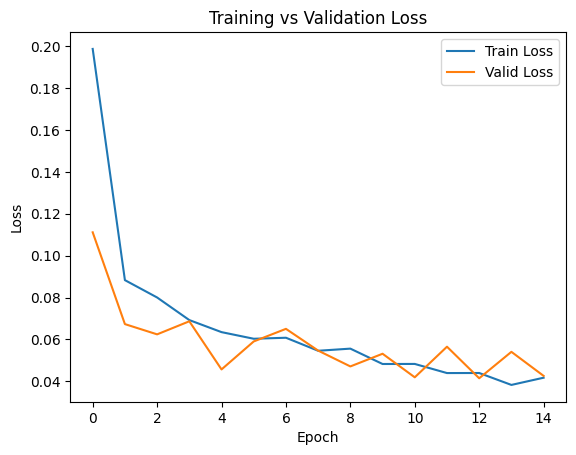

In [40]:
archi = CustomModel()
model_wrapper = SimpleCNN_net(archi, train_, valid_, lr=0.001, weight_decay=0.0005, device=device)
model_wrapper.train(epochs=15)

In [41]:
submission = np.zeros(x_test.shape[0], dtype=np.int64)
submission = model_wrapper.predict(x_test, submission)

In [42]:
submission_df = pd.DataFrame({
    "ImageId": np.arange(1, len(submission) + 1),
    "Label": submission
})
submission_df.to_csv("submission.csv", index=False)

# Some sample examples

(-0.5, 27.5, 27.5, -0.5)

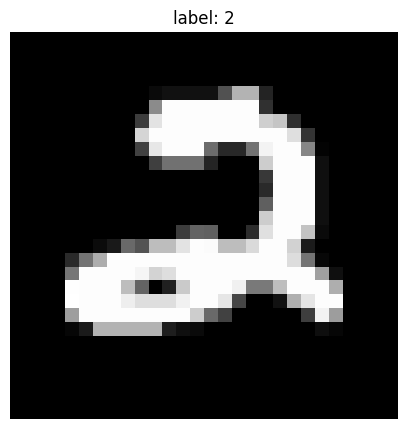

In [46]:
plt.figure(figsize=(5, 7))
plt.imshow(x_test[0], cmap='gray')
plt.title(f"label: {submission[0]}")
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

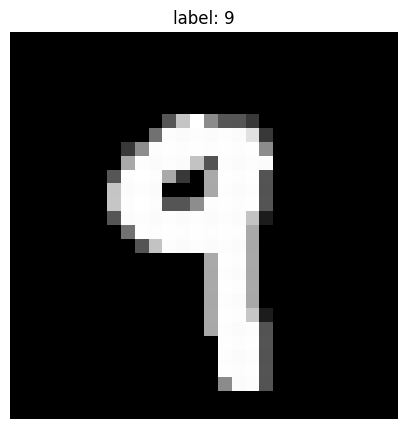

In [47]:
plt.figure(figsize=(5, 7))
plt.imshow(x_test[18], cmap='gray')
plt.title(f"label: {submission[18]}")
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

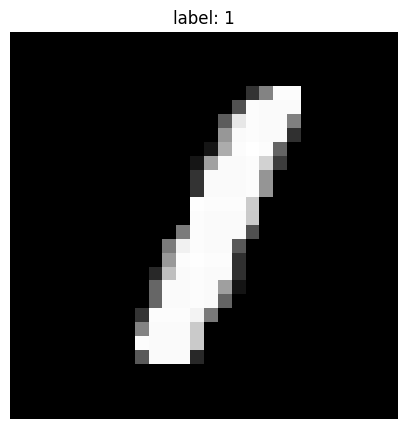

In [48]:
plt.figure(figsize=(5, 7))
plt.imshow(x_test[69], cmap='gray')
plt.title(f"label: {submission[69]}")
plt.axis('off')